# Genetic algorithm Farkle player

The goal of this player is to maximize their individual score in an infinite game. 

For any number of dice remaining there should be a cutoff score at which you would no longer be willing to roll and risk your current score. Rather than directly figure out the expected score from rolling any number of dice I'll just write a genetic algo to backout the threshold score at which you should no longer roll. 

In [1]:
import sys
sys.path.insert(0, '../../src')

import json
import random
from time import perf_counter
import matplotlib.pyplot as plt
from collections import defaultdict

from farkle.game.players import Player
from farkle.logic import gameobjects as go

In [2]:
def unhash_frequencies(hash_to_dh, hash_to_freq):
    _possible_score_freq = {}
    for d in hash_to_freq:
        d_int = int(d)
        _possible_score_freq[d_int] = defaultdict(int)
        for h, freq in hash_to_freq[d].items():
            if hash_to_dh[h] is not None:
                dh = go.DiceHand.json_decode(hash_to_dh[h])
            else:
                dh = None
            _possible_score_freq[d_int][dh] = int(freq)
    return _possible_score_freq

def load_freq(path: str):
    with open(path, 'r') as f:
        j = json.loads(f.read())

    return unhash_frequencies(j['hash_to_dh'], j['hash_to_freq'])

In [3]:
freq_path = '../../../models/possible_score_frequencies.json'
possible_score_frequencies = load_freq(freq_path)

In [4]:
def p_farkle(num_dice: int = None):
    if num_dice == 0: num_dice = 6
    if num_dice is not None:
        return possible_score_frequencies[num_dice][None] / 6**num_dice
    else:
        return {num_dice: possible_score_frequencies[num_dice][None] / 6**num_dice 
                for num_dice in possible_score_frequencies}

In [17]:
def weighted_score(dice_left: int, total_score: int):
    assert dice_left in range(0, 7) and total_score >= 0
    # print('--- ws: ', dice_left, total_score, '---')
    return (1-p_farkle(dice_left)) * (total_score+50)

In [18]:
class GeneticThresholdScorePlayer(Player):
    def __init__(self, name: str, thresholds: dict):
        """
        thresholds : dict
            Keys are num dice remaining and values are the thresholds above which 
            the player will no longer roll again
        """
        super().__init__(name=name)
        self.thresholds = thresholds
                
    def play_dicehand(self, dice_hand: go.DiceHand, game_state: go.GameState) -> go.RollDecision:
        """
        In GameState player ignores everything but dice_hand
        
        score decision logic:
            1. For each possible score determine whether this player will
            choose to roll again using the player's total un-weighted score
            and the remaining dice. 
            2. For those where we roll again take the weighted score. For 
            those where we don't roll again take the unweighted score. 
            3. Choose the scoring option with the largest score from step 2. 
            4. Use the re-roll decision from step 1. 
            
        I don't know that this is the best behavior, I actually think it is not
        """
        ps_list = dice_hand.possible_scores()
        compare_score = []
        roll_again_list = []
        for ps in ps_list:
            dice_left = len(dice_hand.free_dice) - len(ps.free_dice)
            total_score = self.score + dice_hand.score + ps.score
            wght_score = weighted_score(dice_left, total_score)
            
            roll_again = dice_left == 0
            if not roll_again: roll_again = total_score < self.thresholds[dice_left]
            roll_again_list.append(roll_again)
            
            if roll_again: compare_score.append(wght_score)
            else: compare_score.append(total_score)
        
        choose_index = compare_score.index(max(compare_score))
        choose_ps = ps_list[choose_index]
        choose_roll_again = roll_again_list[choose_index]
        
        post_dice_hand = dice_hand.copy()
        post_dice_hand.lock_from_dicehand(choose_ps)
        
        return go.RollDecision(dice_hand, post_dice_hand, choose_roll_again)

In [19]:
# example of behavior I wouldn't do myself
# I would take the 1 and leave the 2,2,2 since seems
# like a waist of 3 dice that would likely get a better score
thresholds = {i+1: 500 + 200 * i for i in range(5)}
name = 'gtsp1'
gtsp = GeneticThresholdScorePlayer(name=name, thresholds=thresholds)
# gtsp.thresholds

dh = go.DiceHand(1,2,2,2,4,3)
# dh

for ps in dh.possible_scores():
    ps: go.DiceHand
    added_score = ps.score
    total_score = dh.score + added_score
    dice_left = len(dh.free_dice) - len(ps.free_dice)
    print(ps)
    print(f'Total score: {total_score}')
    print(f'Dice remaining: {dice_left}')
    print(f'Prob of farkle: {p_farkle(dice_left)}')
    print(f'Weighted score: {(1-p_farkle(dice_left)) * (total_score+50)}')
    print('\n')

game_state = go.GameState(scores={name: 0}, 
                          current_player_name=name, 
                          dice_hand=dh, 
                          goal_score=None)
# game_state

print(gtsp.play_dicehand(dh, game_state))

DiceHand(free=[2, 2, 2], locked=[], score=200)
Total score: 200
Dice remaining: 3
Prob of farkle: 0.2777777777777778
Weighted score: 180.55555555555554


DiceHand(free=[1], locked=[], score=100)
Total score: 100
Dice remaining: 5
Prob of farkle: 0.07716049382716049
Weighted score: 138.42592592592592


DiceHand(free=[1, 2, 2, 2], locked=[], score=300)
Total score: 300
Dice remaining: 2
Prob of farkle: 0.4444444444444444
Weighted score: 194.44444444444446


RollDecision(dicehand_pre=DiceHand(free=[1, 2, 2, 2, 3, 4], locked=[], score=0), dicehand_post=DiceHand(free=[3, 4], locked=[1, 2, 2, 2], score=300), will_roll_again=True)


In [20]:
thresholds = {i+1: 500 + 200 * i for i in range(5)}
name = 'gtsp1'
gtsp = GeneticThresholdScorePlayer(name=name, thresholds=thresholds)
gtsp.score = 300  # can change above behaior if change player score
print(gtsp.thresholds, '\n')

dh = go.DiceHand(1,2,2,2,4,3)
# dh

for ps in dh.possible_scores():
    ps: go.DiceHand
    added_score = ps.score
    total_score = dh.score + added_score + gtsp.score
    dice_left = len(dh.free_dice) - len(ps.free_dice)
    print(ps)
    print(f'Total score: {total_score}')
    print(f'Dice remaining: {dice_left}')
    print(f'Prob of farkle: {p_farkle(dice_left)}')
    print(f'Weighted score: {(1-p_farkle(dice_left)) * (total_score+50)}')
    print('\n')

game_state = go.GameState(scores={name: 0}, 
                          current_player_name=name, 
                          dice_hand=dh, 
                          goal_score=None)
# game_state

print(gtsp.play_dicehand(dh, game_state))

{1: 500, 2: 700, 3: 900, 4: 1100, 5: 1300} 

DiceHand(free=[2, 2, 2], locked=[], score=200)
Total score: 500
Dice remaining: 3
Prob of farkle: 0.2777777777777778
Weighted score: 397.22222222222223


DiceHand(free=[1], locked=[], score=100)
Total score: 400
Dice remaining: 5
Prob of farkle: 0.07716049382716049
Weighted score: 415.27777777777777


DiceHand(free=[1, 2, 2, 2], locked=[], score=300)
Total score: 600
Dice remaining: 2
Prob of farkle: 0.4444444444444444
Weighted score: 361.11111111111114


RollDecision(dicehand_pre=DiceHand(free=[1, 2, 2, 2, 3, 4], locked=[], score=0), dicehand_post=DiceHand(free=[2, 2, 2, 3, 4], locked=[1], score=100), will_roll_again=True)


In [21]:
def lerp_func(x: float):
    assert 0 <= x <= 1
    return x

In [23]:
num_epochs = 40
num_player_turns = 200
num_players = 50

# num_epochs = 1
# num_player_turns = 2
# num_players = 1

default_thresholds = {i+1: 300 + 300 * i for i in range(5)}
threshold_evolution = [default_thresholds]

player_threshold_points_var_start = 100
player_threshold_points_var_end = 30
alpha_start = 0.7  # thresholds updated with alpha weight on new and 1-alpha on old
alpha_end = 0.2
top_percent_players = 0.1  # top % of players by score who's thresholds update for next epoch
top_player_num = max(1, int(num_players * top_percent_players))

t0 = perf_counter()
for epoch_idx in range(num_epochs):
    lerp_factor = lerp_func(epoch_idx / num_epochs)
    alpha = alpha_start * (1 - lerp_factor) + alpha_end * lerp_factor
    player_threshold_points_var = player_threshold_points_var_start * (1 - lerp_factor) + \
        player_threshold_points_var_end * lerp_factor
    print('epoch: ', epoch_idx, ' alpha: ', alpha) #, end=' ')
    # init players for this epoch
    player_thresholds = [{d: int(random.gauss(t, player_threshold_points_var))
                          for d, t in default_thresholds.items()}
                         for p in range(num_players)]
    players = {f'gtsp{p}': GeneticThresholdScorePlayer(name=f'gtsp{p}', 
                                                       thresholds=player_thresholds[p])
               for p in range(num_players)}
    
    for player_name in players:
        # print(player_name, end=', ')
        sys.stdout.write(f'\rplayer {player_name} of {num_players}')
        player = players[player_name]
        # init this players dicehand and this gamestate
        dh = go.DiceHand()
        game_state_pre = go.GameState(scores={player.name: player.score}, 
                                      current_player_name=player.name, 
                                      dice_hand=dh, 
                                      goal_score=None)
        
        for turn_idx in range(num_player_turns):
            dh.reset_dice()
            farkled = False
            will_roll_again = True

            while will_roll_again and not farkled:
                # if player has hot dice and can re-roll all
                if dh.all_locked:
                    dh.roll_all_dice()
                else:
                    dh.roll()
                farkled = dh.farkled
                # print(dh)

                # gen current state before player makes roll decision
                game_state = go.GameState(game_state_pre.scores,
                                          player.name,
                                          dh,
                                          game_state_pre.goal_score)
                # print(game_state_pre.scores)
                if not farkled:
                    roll_decision = player.play_dicehand(dh, game_state)
                    dh = roll_decision.dicehand_post
                    will_roll_again = roll_decision.will_roll_again
                    # print(roll_decision)

            points_earned = dh.score if not farkled else 0
            player.score += points_earned
            # print('score: ', player.score, '\n\n')

    # find players with top x% scores
    best_scores = []  # init w/ 0 so can call max()
    best_thresholds = []
    is_first = True
    for player_name in players:
        if is_first:
            best_scores.append(players[player_name].score)
            best_thresholds.append(players[player_name].thresholds)
            is_first = False
        if players[player_name].score > min(best_scores):
            if len(best_scores) == top_player_num:
                remove_idx = best_scores.index(min(best_scores))
                best_scores.pop(remove_idx)
                best_thresholds.pop(remove_idx)
            elif len(best_scores) > top_player_num:
                print('\n\n\nwtf\n\n\n')

            best_scores.append(players[player_name].score)
            best_thresholds.append(players[player_name].thresholds)
            
    # update thresholds for mean of top x%
    threshold_list = {d: [e[d] for e in best_thresholds] for d in range(1, 6)}
    threshold_avg = {d: sum(l) / len(l) for d, l in threshold_list.items()}
            
    print(f'\nlead {top_player_num} players avg score: {sum(best_scores) / len(best_scores)}')
    # update default_thresholds for lead player
    print('old: ', default_thresholds)
    default_thresholds = {d: int(default_thresholds[d] * (1 - alpha) + threshold_avg[d] * alpha)
                          for d in default_thresholds}
    threshold_evolution.append(default_thresholds)
    print('top: ', threshold_avg)
    print('new: ', default_thresholds, '\n')
    t1 = perf_counter()
    print('time: ', round((t1-t0)/60, 3))
    print('est left: ', round((t1-t0) * (num_epochs - epoch_idx), 2))

epoch:  0  alpha:  0.7
player gtsp49 of 50
lead 5 players avg score: 67640.0
old:  {1: 300, 2: 600, 3: 900, 4: 1200, 5: 1500}
top:  {1: 307.0, 2: 502.6, 3: 924.2, 4: 1280.4, 5: 1463.4}
new:  {1: 304, 2: 531, 3: 916, 4: 1256, 5: 1474} 

time:  4.394
est left:  10545.32
epoch:  1  alpha:  0.6875
player gtsp49 of 50
lead 5 players avg score: 67960.0
old:  {1: 304, 2: 531, 3: 916, 4: 1256, 5: 1474}
top:  {1: 271.6, 2: 565.2, 3: 869.4, 4: 1268.4, 5: 1474.4}
new:  {1: 281, 2: 554, 3: 883, 4: 1264, 5: 1474} 

time:  8.811
est left:  20617.13
epoch:  2  alpha:  0.6749999999999999
player gtsp49 of 50
lead 5 players avg score: 69340.0
old:  {1: 281, 2: 554, 3: 883, 4: 1264, 5: 1474}
top:  {1: 327.8, 2: 544.4, 3: 820.6, 4: 1265.6, 5: 1492.2}
new:  {1: 312, 2: 547, 3: 840, 4: 1265, 5: 1486} 

time:  13.12
est left:  29914.71
epoch:  3  alpha:  0.6625
player gtsp49 of 50
lead 5 players avg score: 68660.0
old:  {1: 312, 2: 547, 3: 840, 4: 1265, 5: 1486}
top:  {1: 361.0, 2: 529.2, 3: 834.4, 4: 1230.2

KeyboardInterrupt: 

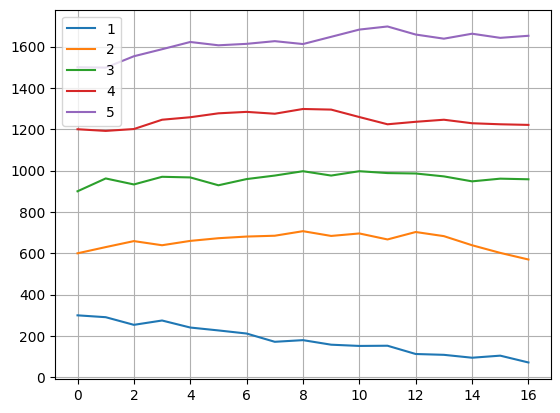

In [12]:
plt_thresholds = {d: [e[d] for e in threshold_evolution] for d in range(1, 6)}

for t in plt_thresholds:
    plt.plot(plt_thresholds[t], label=str(t))
    
plt.grid()
plt.legend()

plt.show()

In [21]:
plt_thresholds = {d: [e[d] for e in threshold_evolution] for d in range(1, 6)}
plt_thresholds

{1: [300,
  304,
  258,
  252,
  260,
  283,
  286,
  275,
  257,
  247,
  200,
  188,
  169,
  141,
  144,
  93,
  137,
  137,
  155,
  177,
  194],
 2: [600,
  633,
  659,
  683,
  759,
  711,
  634,
  629,
  625,
  637,
  694,
  692,
  686,
  667,
  692,
  698,
  710,
  721,
  720,
  711,
  718],
 3: [900,
  899,
  856,
  844,
  790,
  839,
  859,
  844,
  840,
  835,
  837,
  800,
  808,
  841,
  850,
  839,
  850,
  865,
  837,
  853,
  862],
 4: [1200,
  1204,
  1150,
  1181,
  1165,
  1225,
  1220,
  1204,
  1158,
  1133,
  1142,
  1148,
  1151,
  1182,
  1169,
  1188,
  1177,
  1166,
  1129,
  1123,
  1116],
 5: [1500,
  1481,
  1496,
  1476,
  1435,
  1426,
  1433,
  1412,
  1480,
  1455,
  1426,
  1438,
  1457,
  1426,
  1428,
  1424,
  1414,
  1426,
  1417,
  1434,
  1425]}

In [49]:
{d: int(sum(l) / len(l)) for d, l in plt_thresholds.items()}

{1: 289, 2: 581, 3: 881, 4: 1216, 5: 1494}